In [15]:
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

from PIL import Image, ImageFile

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, load_model

In [17]:
DATASET_DIR = r"D:\user\DICOM_images"

IMG_W = 256
IMG_H = 256
CHANNELS = 3

INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
EPOCHS = 10
BATCH_SIZE = 32

In [3]:
category_list = os.listdir(DATASET_DIR)
category_list

['CR-CHEST',
 'CT-ABDOMEN',
 'CT-BREAST',
 'CT-CHEST',
 'CT-COLON',
 'CT-HEADNECK',
 'CT-KIDNEY',
 'CT-LUNG',
 'CT-PANCREAS',
 'DX-CHEST',
 'MG-BREAST',
 'MR-ABDOMEN',
 'MR-BRAIN',
 'MR-BREAST',
 'MR-HEADNECK',
 'MR-KIDNEY',
 'MR-PELVIS',
 'MR-PROSTATE']

In [ ]:
from PIL import Image

for root, dirs, files in os.walk(BASE_PATH):
    rootpath = os.path.join(os.path.abspath(BASE_PATH), root)
    
    for file in files:
        filepath = os.path.join(rootpath, file)
        print(filepath)
#         img = Image.open(filepath)
#         img_resize = img.resize((IMG_W, IMG_H))
#         img_resize.save(filepath)

In [4]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    brightness_range=[0.8, 1.2],
    shear_range=0.01,
    zoom_range=[0.9, 1.1],
    validation_split=0.25,
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    validation_split=0.25,
    preprocessing_function=preprocess_input
)

In [5]:
train_gen = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_W, IMG_H),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_W, IMG_H),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    subset='validation'
)

Found 43328 images belonging to 18 classes.
Found 14435 images belonging to 18 classes.


In [6]:
print(val_gen.class_indices)

{'CR-CHEST': 0, 'CT-ABDOMEN': 1, 'CT-BREAST': 2, 'CT-CHEST': 3, 'CT-COLON': 4, 'CT-HEADNECK': 5, 'CT-KIDNEY': 6, 'CT-LUNG': 7, 'CT-PANCREAS': 8, 'DX-CHEST': 9, 'MG-BREAST': 10, 'MR-ABDOMEN': 11, 'MR-BRAIN': 12, 'MR-BREAST': 13, 'MR-HEADNECK': 14, 'MR-KIDNEY': 15, 'MR-PELVIS': 16, 'MR-PROSTATE': 17}


In [7]:
base_model = MobileNetV2(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)
 
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(category_list), activation='softmax')(x)
 
model = Model(inputs=base_model.input, outputs=output)

C:\Users\user\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [8]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [10]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping

MODEL_SAVE_FOLDER_PATH = "./model_saved"
LOG_SAVE_FOLDER_PATH = "./logs"
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)
if not os.path.exists(LOG_SAVE_FOLDER_PATH):
    os.mkdir(LOG_SAVE_FOLDER_PATH)
model_path = MODEL_SAVE_FOLDER_PATH + "\\" + "{val_accuracy:.2f}-model.h5"

In [16]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [18]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch = train_gen.samples // BATCH_SIZE,
    validation_data = val_gen,
    validation_steps = val_gen.samples // BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [
        ModelCheckpoint(filepath=model_path, monitor="val_accuracy", verbose=1, save_best_only=True),
        TensorBoard(log_dir=LOG_SAVE_FOLDER_PATH, histogram_freq=0, write_graph=True, write_images=True),
        EarlyStopping(monitor="val_accuracy", min_delta=0.6, patience=4, verbose=0)
    ])

Epoch 1/10
1354/1354 [==============================] - 7976s 6s/step - loss: 0.1634 - accuracy: 0.9438 - val_loss: 20.9419 - val_accuracy: 0.5394

Epoch 00001: val_accuracy improved from -inf to 0.53936, saving model to ./model_saved\0.54-model.h5
Epoch 2/10
1354/1354 [==============================] - 7984s 6s/step - loss: 0.1479 - accuracy: 0.9496 - val_loss: 0.0031 - val_accuracy: 0.6558

Epoch 00002: val_accuracy improved from 0.53936 to 0.65576, saving model to ./model_saved\0.66-model.h5
Epoch 3/10
1354/1354 [==============================] - 7993s 6s/step - loss: 0.1180 - accuracy: 0.9616 - val_loss: 2.9802e-07 - val_accuracy: 0.3519

Epoch 00003: val_accuracy did not improve from 0.65576
Epoch 4/10
1354/1354 [==============================] - 7986s 6s/step - loss: 0.1137 - accuracy: 0.9602 - val_loss: 4.2346 - val_accuracy: 0.3439

Epoch 00004: val_accuracy did not improve from 0.65576
Epoch 5/10
1354/1354 [==============================] - 7986s 6s/step - loss: 0.1021 - accur

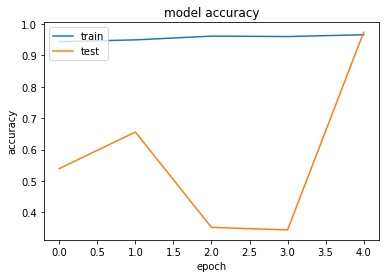

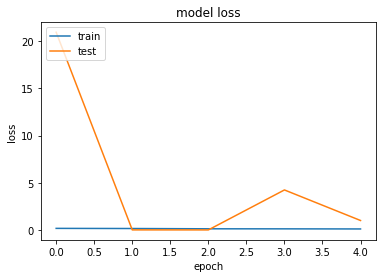

In [19]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
print("training_accuracy", history.history['accuracy'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

training_accuracy 0.9660266
validation_accuracy 0.9739468097686768


In [25]:
label = val_gen.classes
print(label)

[ 0  0  0 ... 17 17 17]


In [26]:
pred = model.predict(val_gen)
predicted_class_indices = np.argmax(pred, axis=1)
labels = (val_gen.class_indices)  
labels2 = dict((v, k) for k, v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print(labels)
print(predictions)

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(predicted_class_indices, label)

In [ ]:
exp_series = pd.Series(label)
pred_series = pd.Series(predicted_class_indices)
pd.crosstab(exp_series, pred_series, rownames=["Actual"], colnames=["Predicted"], margins=True)

In [27]:
model = load_model(os.path.join("model_saved", "0.97-model.h5"))

In [ ]:
# img_data = os.path.join(BASE_PATH, 'MG', 'BREAST', 'MG-1.3.6.1.4.1.14519.5.2.1.2135.6389.196448195523288006097403759182.png')
img_data = r"D:\DICOM_Image_File\MR\BREAST\MR-1.3.6.1.4.1.14519.5.2.1.4792.2001.100016046418120980071813913349.png"
test_img = img_to_array(load_img(img_data, target_size=(512, 512)))
test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))

pred = model.predict(test_input)
predicted_class_indices = np.argmax(pred, axis=1)
print(pred)
labels = (val_gen.class_indices)
print(labels)
labels2 = dict((v, k) for k, v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]
print(predictions)

plt.figure(figsize=(8, 8))
plt.title('%.2f%% ' % (pred[0][predicted_class_indices] * 100) + str(predictions))
plt.axis("off")
plt.imshow(test_img, cmap=plt.cm.gray)